In this Python Google Colab Notebook I have used an LSTM Recurrent Deep Neural Network to make a Time-Series Forecasting.
IN this case trying to predict future Comsumptions values based on an hourly Consumption (KW/h) Dataset.
If you replace the CSV File It would adapt to a lot of similar use cases.

In [1]:
# Importing the necesary packages:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
# Upload your .csv file
files.upload()

Saving energy_consumption.csv to energy_consumption.csv


{'energy_consumption.csv': b',0\n2022-01-01 15:00:00,2.1675\n2022-01-01 16:00:00,1.9300000000000002\n2022-01-01 17:00:00,2.2075\n2022-01-01 18:00:00,2.055\n2022-01-01 19:00:00,1.987499999999999\n2022-01-01 20:00:00,2.1125\n2022-01-01 21:00:00,2.07\n2022-01-01 22:00:00,1.835\n2022-01-01 23:00:00,2.08\n2022-01-02 00:00:00,1.8450000000000002\n2022-01-02 01:00:00,0.8699999999999991\n2022-01-02 02:00:00,0.759999999999999\n2022-01-02 03:00:00,1.4625\n2022-01-02 04:00:00,0.845\n2022-01-02 05:00:00,1.34\n2022-01-02 06:00:00,0.7975000000000001\n2022-01-02 07:00:00,1.315\n2022-01-02 08:00:00,0.8300000000000001\n2022-01-02 09:00:00,1.3325\n2022-01-02 10:00:00,0.75\n2022-01-02 11:00:00,1.26\n2022-01-02 12:00:00,2.2525\n2022-01-02 13:00:00,2.56\n2022-01-02 14:00:00,2.39\n2022-01-02 15:00:00,2.415\n2022-01-02 16:00:00,2.565\n2022-01-02 17:00:00,2.5975\n2022-01-02 18:00:00,2.247499999999999\n2022-01-02 19:00:00,2.5025\n2022-01-02 20:00:00,2.5375\n2022-01-02 21:00:00,2.3675\n2022-01-02 22:00:00,2.4050

In [3]:
# Crate a Pandas DatFrame to manage the data of your .csv file
## Put your file name inside the parenthesis
df = pd.read_csv("energy_consumption.csv")
# Visualize the fist raws of the DatFrame
df.head()

,Unnamed: 0,0
0,2022-01-01 15:00:00,2.1675
1,2022-01-01 16:00:00,1.9300
2,2022-01-01 17:00:00,2.2075
3,2022-01-01 18:00:00,2.0550
4,2022-01-01 19:00:00,1.9875


In [4]:
# View some general statistics of th data
df.describe()

,0
count,2161.000000
mean,2.014631
std,0.712402
min,0.029200
25%,1.425000
50%,2.170000
75%,2.585000
max,3.790000


In [5]:
# General information of the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2161 non-null   object 
 1   0           2161 non-null   float64
dtypes: float64(1), object(1)
memory usage: 33.9+ KB


In [6]:
# Renaming the columns to be self-expainable
df.columns=["Date", "Consumption"]
df.head()

,Date,Consumption
0,2022-01-01 15:00:00,2.1675
1,2022-01-01 16:00:00,1.9300
2,2022-01-01 17:00:00,2.2075
3,2022-01-01 18:00:00,2.0550
4,2022-01-01 19:00:00,1.9875


df.columns=["Date", "Consumption"]
df.head(3)

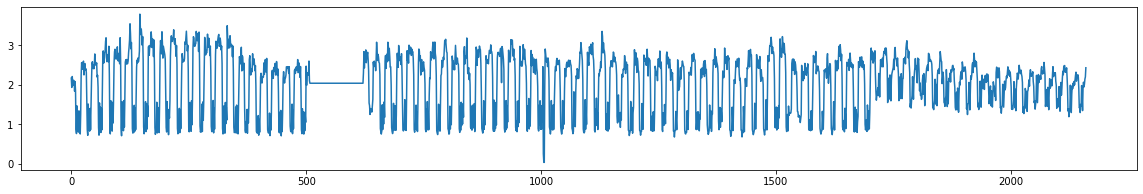

In [7]:
# Configuring plot size
plt.figure(figsize=(20, 3))
# Plotting the feature´s column against the index column
cons = df['Consumption']
cons.plot()

In [8]:
# Viewing the shape of the column (or the number of registers)
cons.shape

(2161,)

In [9]:
# Defining a function to create subsets
def df_to_X_y(df, window_size=12):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
# Defining vectors to create training and test sets to feed the neural network
WINDOW_SIZE = 12
X1, y1 = df_to_X_y(cons, WINDOW_SIZE)
X1.shape, y1.shape

((2149, 12, 1), (2149,))

In [11]:
# Create limits to divide the trainging, validation and test sets
training_limit = int(len(X1) * 0.7)
print(f'training_limit: {training_limit}')

training_limit: 1504


In [12]:
rest = len(X1)-training_limit
print(rest)

645


In [13]:
validation_limit = int(rest*0.4)
print(f'validation_limit: {validation_limit}')

validation_limit: 258


In [14]:
# Generating training, validation and test sets
X_train1, y_train1 = X1[:training_limit], y1[:training_limit]
X_val1, y_val1 = X1[training_limit:(training_limit+validation_limit)], y1[training_limit:(training_limit+validation_limit)]
X_test1, y_test1 = X1[(training_limit+validation_limit):], y1[(training_limit+validation_limit):]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1504, 12, 1), (1504,), (258, 12, 1), (258,), (387, 12, 1), (387,))

In [15]:
# Importing packages to create the Neural Network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [58]:
# If you already have a trained model ("model.h5"), here you can upload it instead of creating a new model
#files.upload()

In [59]:
# import THE TRAINED MODEL
#tf.keras.models.load_model("model1.h5")
#print("The Trianed Model was Imported Succesfully")

In [16]:
# Creating model 1: LSTM Recurrent Deep Neural Network

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(128))
model1.add(Dense(64))
model1.add(Dense(64))
model1.add(Dense(64))
model1.add(Dropout(0.3))
model1.add(Dense(64))
model1.add(Dropout(0.3))
model1.add(Dense(16))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4

In [17]:
# Compiling the model
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [18]:
# Training process of the Neural Network model
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
45/47 [===========================>..] - ETA: 0s - loss: 3.9214 - root_mean_squared_error: 1.9802

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 13s 115ms/step - loss: 3.8498 - root_mean_squared_error: 1.9621 - val_loss: 1.8088 - val_root_mean_squared_error: 1.3449
Epoch 2/50
39/47 [=======================>......] - ETA: 0s - loss: 1.1790 - root_mean_squared_error: 1.0858

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 105ms/step - loss: 1.0917 - root_mean_squared_error: 1.0449 - val_loss: 0.3745 - val_root_mean_squared_error: 0.6120
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.7033 - root_mean_squared_error: 0.8387

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 106ms/step - loss: 0.7033 - root_mean_squared_error: 0.8387 - val_loss: 0.3455 - val_root_mean_squared_error: 0.5878
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.6434 - root_mean_squared_error: 0.8021

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 106ms/step - loss: 0.6434 - root_mean_squared_error: 0.8021 - val_loss: 0.3188 - val_root_mean_squared_error: 0.5646
Epoch 5/50
36/47 [=====================>........] - ETA: 0s - loss: 0.5914 - root_mean_squared_error: 0.7690

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 115ms/step - loss: 0.5873 - root_mean_squared_error: 0.7664 - val_loss: 0.2832 - val_root_mean_squared_error: 0.5322
Epoch 6/50
47/47 [==============================] - ETA: 0s - loss: 0.5198 - root_mean_squared_error: 0.7210

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 106ms/step - loss: 0.5198 - root_mean_squared_error: 0.7210 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5005
Epoch 7/50
36/47 [=====================>........] - ETA: 0s - loss: 0.4627 - root_mean_squared_error: 0.6802

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 105ms/step - loss: 0.4652 - root_mean_squared_error: 0.6821 - val_loss: 0.2341 - val_root_mean_squared_error: 0.4839
Epoch 8/50
37/47 [======================>.......] - ETA: 0s - loss: 0.4074 - root_mean_squared_error: 0.6383

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.4129 - root_mean_squared_error: 0.6425 - val_loss: 0.1837 - val_root_mean_squared_error: 0.4286
Epoch 9/50
37/47 [======================>.......] - ETA: 0s - loss: 0.3894 - root_mean_squared_error: 0.6240

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 108ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4067
Epoch 10/50
37/47 [======================>.......] - ETA: 0s - loss: 0.3546 - root_mean_squared_error: 0.5954

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 105ms/step - loss: 0.3507 - root_mean_squared_error: 0.5922 - val_loss: 0.1554 - val_root_mean_squared_error: 0.3942
Epoch 11/50
38/47 [=======================>......] - ETA: 0s - loss: 0.3303 - root_mean_squared_error: 0.5747

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 107ms/step - loss: 0.3324 - root_mean_squared_error: 0.5765 - val_loss: 0.1452 - val_root_mean_squared_error: 0.3811
Epoch 12/50
47/47 [==============================] - 0s 6ms/step - loss: 0.3154 - root_mean_squared_error: 0.5616 - val_loss: 0.1474 - val_root_mean_squared_error: 0.3839
Epoch 13/50
38/47 [=======================>......] - ETA: 0s - loss: 0.3199 - root_mean_squared_error: 0.5656

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.3161 - root_mean_squared_error: 0.5622 - val_loss: 0.1438 - val_root_mean_squared_error: 0.3792
Epoch 14/50
35/47 [=====================>........] - ETA: 0s - loss: 0.3154 - root_mean_squared_error: 0.5616

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 109ms/step - loss: 0.3078 - root_mean_squared_error: 0.5548 - val_loss: 0.1429 - val_root_mean_squared_error: 0.3780
Epoch 15/50
36/47 [=====================>........] - ETA: 0s - loss: 0.3112 - root_mean_squared_error: 0.5578

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 105ms/step - loss: 0.3108 - root_mean_squared_error: 0.5575 - val_loss: 0.1411 - val_root_mean_squared_error: 0.3756
Epoch 16/50
47/47 [==============================] - 0s 5ms/step - loss: 0.3157 - root_mean_squared_error: 0.5618 - val_loss: 0.1479 - val_root_mean_squared_error: 0.3845
Epoch 17/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2901 - root_mean_squared_error: 0.5386 - val_loss: 0.1480 - val_root_mean_squared_error: 0.3847
Epoch 18/50
39/47 [=======================>......] - ETA: 0s - loss: 0.2830 - root_mean_squared_error: 0.5319

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 105ms/step - loss: 0.2833 - root_mean_squared_error: 0.5323 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 19/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2841 - root_mean_squared_error: 0.5330 - val_loss: 0.1401 - val_root_mean_squared_error: 0.3743
Epoch 20/50
37/47 [======================>.......] - ETA: 0s - loss: 0.2723 - root_mean_squared_error: 0.5218

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 104ms/step - loss: 0.2681 - root_mean_squared_error: 0.5177 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 21/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440 - val_loss: 0.1655 - val_root_mean_squared_error: 0.4069
Epoch 22/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2784 - root_mean_squared_error: 0.5276 - val_loss: 0.1426 - val_root_mean_squared_error: 0.3777
Epoch 23/50
47/47 [==============================] - ETA: 0s - loss: 0.2741 - root_mean_squared_error: 0.5236

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 106ms/step - loss: 0.2741 - root_mean_squared_error: 0.5236 - val_loss: 0.1379 - val_root_mean_squared_error: 0.3713
Epoch 24/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2871 - root_mean_squared_error: 0.5358 - val_loss: 0.1604 - val_root_mean_squared_error: 0.4004
Epoch 25/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2779 - root_mean_squared_error: 0.5272 - val_loss: 0.1381 - val_root_mean_squared_error: 0.3716
Epoch 26/50
38/47 [=======================>......] - ETA: 0s - loss: 0.2498 - root_mean_squared_error: 0.4998

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090 - val_loss: 0.1374 - val_root_mean_squared_error: 0.3707
Epoch 27/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2806 - root_mean_squared_error: 0.5297 - val_loss: 0.1399 - val_root_mean_squared_error: 0.3740
Epoch 28/50
37/47 [======================>.......] - ETA: 0s - loss: 0.2649 - root_mean_squared_error: 0.5147

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 110ms/step - loss: 0.2598 - root_mean_squared_error: 0.5097 - val_loss: 0.1361 - val_root_mean_squared_error: 0.3690
Epoch 29/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041 - val_loss: 0.1427 - val_root_mean_squared_error: 0.3777
Epoch 30/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2549 - root_mean_squared_error: 0.5049 - val_loss: 0.1385 - val_root_mean_squared_error: 0.3721
Epoch 31/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285 - val_loss: 0.1678 - val_root_mean_squared_error: 0.4096
Epoch 32/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139 - val_loss: 0.1364 - val_root_mean_squared_error: 0.3693
Epoch 33/50
39/47 [=======================>......] - ETA: 0s - loss: 0.2475 - root_mean_squared_error: 0.4975

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 6s 123ms/step - loss: 0.2542 - root_mean_squared_error: 0.5042 - val_loss: 0.1340 - val_root_mean_squared_error: 0.3660
Epoch 34/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2588 - root_mean_squared_error: 0.5087 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3926
Epoch 35/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2602 - root_mean_squared_error: 0.5101 - val_loss: 0.1503 - val_root_mean_squared_error: 0.3876
Epoch 36/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2513 - root_mean_squared_error: 0.5013 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3710
Epoch 37/50
38/47 [=======================>......] - ETA: 0s - loss: 0.2554 - root_mean_squared_error: 0.5054

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 107ms/step - loss: 0.2579 - root_mean_squared_error: 0.5079 - val_loss: 0.1324 - val_root_mean_squared_error: 0.3638
Epoch 38/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998 - val_loss: 0.1381 - val_root_mean_squared_error: 0.3716
Epoch 39/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2538 - root_mean_squared_error: 0.5037 - val_loss: 0.1343 - val_root_mean_squared_error: 0.3665
Epoch 40/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027 - val_loss: 0.1329 - val_root_mean_squared_error: 0.3646
Epoch 41/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2593 - root_mean_squared_error: 0.5093 - val_loss: 0.1402 - val_root_mean_squared_error: 0.3744
Epoch 42/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991 - val_loss: 0.1359 - val_root_mean_square

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 98ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001 - val_loss: 0.1300 - val_root_mean_squared_error: 0.3606
Epoch 46/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3624
Epoch 47/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3624
Epoch 48/50
37/47 [======================>.......] - ETA: 0s - loss: 0.2461 - root_mean_squared_error: 0.4961

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


47/47 [==============================] - 5s 107ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915 - val_loss: 0.1295 - val_root_mean_squared_error: 0.3598
Epoch 49/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3708
Epoch 50/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2432 - root_mean_squared_error: 0.4931 - val_loss: 0.1340 - val_root_mean_squared_error: 0.3661


In [19]:
# Making training predictions
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results[0:20]

,Train Predictions,Actuals
0,1.074975,1.4625
1,1.392000,0.8450
2,1.183689,1.3400
3,1.429636,0.7975
4,1.256709,1.3150
5,1.498594,0.8300
6,1.358072,1.3325
7,1.591900,0.7500
8,1.390833,1.2600
9,1.598595,2.2525


In [20]:
### Calculate the Training  Root Mean Squared Error
import math
from sklearn.metrics import mean_squared_error
mse_train1 = math.sqrt(mean_squared_error(train_predictions,y_train1))
print(mse_train1)

0.4168869523427962


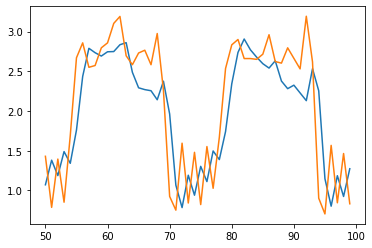

In [21]:
# Plotting the training predictions
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [22]:
# Making validation predictions
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,2.759380,2.8050
1,2.523223,3.0500
2,2.562683,3.0200
3,2.502549,2.7750
4,2.288914,2.7725
...,...,...
253,1.953086,1.6475
254,1.728427,2.1375
255,1.965689,2.1575
256,2.044678,2.6600


In [23]:
mse_val1 = math.sqrt(mean_squared_error(val_predictions,y_val1))
print(mse_val1)

0.3660569430753129


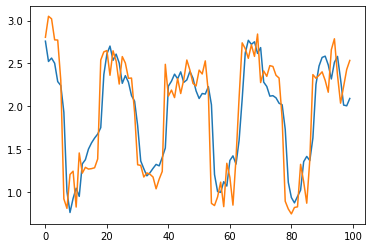

In [24]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [25]:
# Making the Test Predictions (future predictions)
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

,Test Predictions,Actuals
0,2.414339,2.5725
1,2.409770,2.7000
2,2.464833,2.5275
3,2.354355,2.9175
4,2.552645,3.0425
...,...,...
382,2.079851,1.9425
383,2.076596,2.0125
384,2.114419,2.1425
385,2.175813,2.1975


In [26]:
mse_test1 = math.sqrt(mean_squared_error(test_predictions,y_test1))
print(mse_test1)

0.26273624331107553


In [27]:
cons_max = cons.max()
print(cons_max)

3.79


In [28]:
# Calculating the % of Error
Error_percentage = round(((mse_test1*100)/cons_max), 2)
print(Error_percentage)

6.93


In [29]:
# Calculating the Model Precision
model1_precision = 100-Error_percentage
print(" The Model Precision is :  ", model1_precision, "%")

 The Model Precision is :   93.07 %


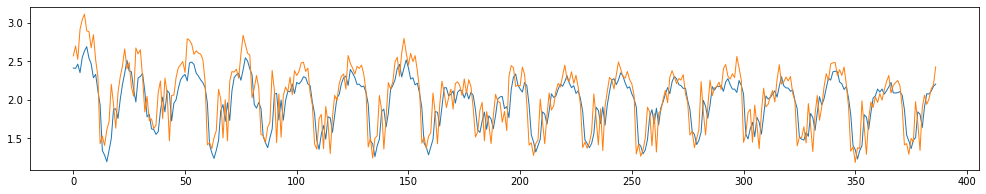

In [30]:
plt.figure(figsize=(17, 3))
plt.plot(test_results['Test Predictions'],lw=1)
plt.plot(test_results['Actuals'],lw=1)

In [31]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=2000):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

(     Predictions  Actuals
 0       3.076068   2.6950
 1       2.907410   2.8725
 2       2.898319   3.2200
 3       3.030395   3.0500
 4       2.917660   2.8050
 ..           ...      ...
 644     2.167289   1.9425
 645     2.170667   2.0125
 646     2.205222   2.1425
 647     2.267917   2.1975
 648     2.302845   2.4300
 
 [649 rows x 2 columns], 0.09278107075051861)

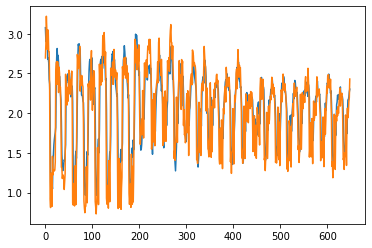

In [ ]:
plot_predictions1(model1, X_test1, y_test1)

In [32]:
# Saving the Trained Neural Network Model
model1.save("model1.h5")

In [33]:
!ls

energy_consumption.csv	model1	model1.h5  sample_data


In [34]:
# Downloading the Trained Neural Network Model
from google.colab import files
files.download("model1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# Creating Model 2:

model2 = Sequential()
model2.add(InputLayer((12, 1)))
model2.add(LSTM(256))
model2.add(Dense(256))
#model2.add(Dense(128))
#model1.add(Dense(64))
#model1.add(Dense(64))
model2.add(Dropout(0.3))
#model1.add(Dense(64))
#model1.add(Dropout(0.3))
#model1.add(Dense(16))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 332,049
Trainable params: 332,049
Non-trainable params: 0
_________________________________________________________________


In [36]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [37]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=60, callbacks=[cp2])

Epoch 1/60
37/47 [======================>.......] - ETA: 0s - loss: 1.5223 - root_mean_squared_error: 1.2338

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 6s 106ms/step - loss: 1.3311 - root_mean_squared_error: 1.1537 - val_loss: 0.4594 - val_root_mean_squared_error: 0.6778
Epoch 2/60
36/47 [=====================>........] - ETA: 0s - loss: 0.5750 - root_mean_squared_error: 0.7583

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 90ms/step - loss: 0.5705 - root_mean_squared_error: 0.7553 - val_loss: 0.3738 - val_root_mean_squared_error: 0.6114
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 0.4752 - root_mean_squared_error: 0.6893

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 101ms/step - loss: 0.4752 - root_mean_squared_error: 0.6893 - val_loss: 0.3134 - val_root_mean_squared_error: 0.5598
Epoch 4/60
36/47 [=====================>........] - ETA: 0s - loss: 0.4170 - root_mean_squared_error: 0.6458

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.3965 - root_mean_squared_error: 0.6296 - val_loss: 0.2376 - val_root_mean_squared_error: 0.4874
Epoch 5/60
45/47 [===========================>..] - ETA: 0s - loss: 0.3061 - root_mean_squared_error: 0.5533

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 104ms/step - loss: 0.3030 - root_mean_squared_error: 0.5505 - val_loss: 0.1845 - val_root_mean_squared_error: 0.4296
Epoch 6/60
47/47 [==============================] - ETA: 0s - loss: 0.2527 - root_mean_squared_error: 0.5027

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118
Epoch 7/60
36/47 [=====================>........] - ETA: 0s - loss: 0.2457 - root_mean_squared_error: 0.4956

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 100ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824 - val_loss: 0.1520 - val_root_mean_squared_error: 0.3899
Epoch 8/60
47/47 [==============================] - 0s 5ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663 - val_loss: 0.1543 - val_root_mean_squared_error: 0.3928
Epoch 9/60
47/47 [==============================] - 0s 6ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643 - val_loss: 0.1616 - val_root_mean_squared_error: 0.4019
Epoch 10/60
37/47 [======================>.......] - ETA: 0s - loss: 0.2178 - root_mean_squared_error: 0.4667

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 98ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651 - val_loss: 0.1456 - val_root_mean_squared_error: 0.3816
Epoch 11/60
47/47 [==============================] - 0s 5ms/step - loss: 0.2056 - root_mean_squared_error: 0.4535 - val_loss: 0.1517 - val_root_mean_squared_error: 0.3895
Epoch 12/60
47/47 [==============================] - 0s 6ms/step - loss: 0.2069 - root_mean_squared_error: 0.4548 - val_loss: 0.1469 - val_root_mean_squared_error: 0.3833
Epoch 13/60
47/47 [==============================] - ETA: 0s - loss: 0.2029 - root_mean_squared_error: 0.4505

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.2029 - root_mean_squared_error: 0.4505 - val_loss: 0.1439 - val_root_mean_squared_error: 0.3794
Epoch 14/60
47/47 [==============================] - 0s 6ms/step - loss: 0.2068 - root_mean_squared_error: 0.4547 - val_loss: 0.1467 - val_root_mean_squared_error: 0.3830
Epoch 15/60
37/47 [======================>.......] - ETA: 0s - loss: 0.2021 - root_mean_squared_error: 0.4495

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.2025 - root_mean_squared_error: 0.4500 - val_loss: 0.1408 - val_root_mean_squared_error: 0.3752
Epoch 16/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1991 - root_mean_squared_error: 0.4462 - val_loss: 0.1423 - val_root_mean_squared_error: 0.3772
Epoch 17/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465 - val_loss: 0.1468 - val_root_mean_squared_error: 0.3832
Epoch 18/60
38/47 [=======================>......] - ETA: 0s - loss: 0.1972 - root_mean_squared_error: 0.4440

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 98ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497 - val_loss: 0.1385 - val_root_mean_squared_error: 0.3722
Epoch 19/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1954 - root_mean_squared_error: 0.4420 - val_loss: 0.1394 - val_root_mean_squared_error: 0.3733
Epoch 20/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1923 - root_mean_squared_error: 0.4385 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3724
Epoch 21/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461 - val_loss: 0.1402 - val_root_mean_squared_error: 0.3745
Epoch 22/60
47/47 [==============================] - 0s 6ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474 - val_loss: 0.1401 - val_root_mean_squared_error: 0.3743
Epoch 23/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.1437 - val_root_mean_squared

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 90ms/step - loss: 0.1923 - root_mean_squared_error: 0.4385 - val_loss: 0.1345 - val_root_mean_squared_error: 0.3668
Epoch 25/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1921 - root_mean_squared_error: 0.4382 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 26/60
47/47 [==============================] - ETA: 0s - loss: 0.1904 - root_mean_squared_error: 0.4363

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 100ms/step - loss: 0.1904 - root_mean_squared_error: 0.4363 - val_loss: 0.1340 - val_root_mean_squared_error: 0.3661
Epoch 27/60
36/47 [=====================>........] - ETA: 0s - loss: 0.1819 - root_mean_squared_error: 0.4265

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 98ms/step - loss: 0.1877 - root_mean_squared_error: 0.4332 - val_loss: 0.1320 - val_root_mean_squared_error: 0.3634
Epoch 28/60
47/47 [==============================] - 0s 6ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497 - val_loss: 0.1420 - val_root_mean_squared_error: 0.3769
Epoch 29/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369 - val_loss: 0.1344 - val_root_mean_squared_error: 0.3666
Epoch 30/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338 - val_loss: 0.1349 - val_root_mean_squared_error: 0.3673
Epoch 31/60
36/47 [=====================>........] - ETA: 0s - loss: 0.1824 - root_mean_squared_error: 0.4271

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 90ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328 - val_loss: 0.1299 - val_root_mean_squared_error: 0.3604
Epoch 32/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1870 - root_mean_squared_error: 0.4324 - val_loss: 0.1306 - val_root_mean_squared_error: 0.3614
Epoch 33/60
47/47 [==============================] - ETA: 0s - loss: 0.1860 - root_mean_squared_error: 0.4313

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.1860 - root_mean_squared_error: 0.4313 - val_loss: 0.1295 - val_root_mean_squared_error: 0.3599
Epoch 34/60
37/47 [======================>.......] - ETA: 0s - loss: 0.1832 - root_mean_squared_error: 0.4280

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299 - val_loss: 0.1274 - val_root_mean_squared_error: 0.3569
Epoch 35/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1824 - root_mean_squared_error: 0.4270 - val_loss: 0.1288 - val_root_mean_squared_error: 0.3589
Epoch 36/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231 - val_loss: 0.1277 - val_root_mean_squared_error: 0.3574
Epoch 37/60
39/47 [=======================>......] - ETA: 0s - loss: 0.1743 - root_mean_squared_error: 0.4175

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 100ms/step - loss: 0.1807 - root_mean_squared_error: 0.4251 - val_loss: 0.1269 - val_root_mean_squared_error: 0.3563
Epoch 38/60
37/47 [======================>.......] - ETA: 0s - loss: 0.1712 - root_mean_squared_error: 0.4138

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 96ms/step - loss: 0.1763 - root_mean_squared_error: 0.4199 - val_loss: 0.1263 - val_root_mean_squared_error: 0.3554
Epoch 39/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1744 - root_mean_squared_error: 0.4176 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3577
Epoch 40/60
47/47 [==============================] - 0s 7ms/step - loss: 0.1805 - root_mean_squared_error: 0.4248 - val_loss: 0.1368 - val_root_mean_squared_error: 0.3699
Epoch 41/60
40/47 [========================>.....] - ETA: 0s - loss: 0.1849 - root_mean_squared_error: 0.4300

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.1795 - root_mean_squared_error: 0.4237 - val_loss: 0.1263 - val_root_mean_squared_error: 0.3554
Epoch 42/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1730 - root_mean_squared_error: 0.4159 - val_loss: 0.1318 - val_root_mean_squared_error: 0.3630
Epoch 43/60
47/47 [==============================] - ETA: 0s - loss: 0.1732 - root_mean_squared_error: 0.4162

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 99ms/step - loss: 0.1732 - root_mean_squared_error: 0.4162 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3476
Epoch 44/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1694 - root_mean_squared_error: 0.4115 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3485
Epoch 45/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1673 - root_mean_squared_error: 0.4090 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 46/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1712 - root_mean_squared_error: 0.4137 - val_loss: 0.1217 - val_root_mean_squared_error: 0.3489
Epoch 47/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1683 - root_mean_squared_error: 0.4103 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 48/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1681 - root_mean_squared_error: 0.4100 - val_loss: 0.1287 - val_root_mean_squared

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 4s 88ms/step - loss: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.1187 - val_root_mean_squared_error: 0.3446
Epoch 50/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1650 - root_mean_squared_error: 0.4063 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 51/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1655 - root_mean_squared_error: 0.4068 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3448
Epoch 52/60
37/47 [======================>.......] - ETA: 0s - loss: 0.1651 - root_mean_squared_error: 0.4063

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


47/47 [==============================] - 5s 100ms/step - loss: 0.1622 - root_mean_squared_error: 0.4027 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3433
Epoch 53/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1632 - root_mean_squared_error: 0.4040 - val_loss: 0.1186 - val_root_mean_squared_error: 0.3444
Epoch 54/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1609 - root_mean_squared_error: 0.4012 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 55/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1568 - root_mean_squared_error: 0.3960 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3590
Epoch 56/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1573 - root_mean_squared_error: 0.3967 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3460
Epoch 57/60
47/47 [==============================] - 0s 5ms/step - loss: 0.1589 - root_mean_squared_error: 0.3986 - val_loss: 0.1210 - val_root_mean_square

In [38]:
train_predictions2 = model2.predict(X_train1).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions2':train_predictions2, 'Actuals':y_train1})
train_results2[0:20]

,Train Predictions2,Actuals
0,0.983039,1.4625
1,1.302544,0.8450
2,1.075726,1.3400
3,1.375853,0.7975
4,1.119402,1.3150
5,1.531866,0.8300
6,1.339653,1.3325
7,1.728234,0.7500
8,1.437743,1.2600
9,1.708364,2.2525


In [39]:
# Calculate the Training % of Error (RMSE) performance metrics
import math
from sklearn.metrics import mean_squared_error
mse_train2 = math.sqrt(mean_squared_error(train_predictions2,y_train1))
print(mse_train2)

0.3688097937549145


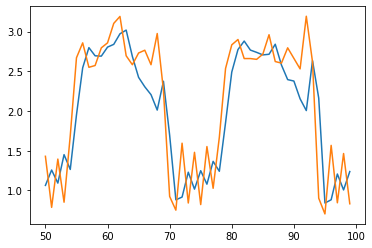

In [40]:
import matplotlib.pyplot as plt
plt.plot(train_results2['Train Predictions2'][50:100])
plt.plot(train_results2['Actuals'][50:100])

In [41]:
val_predictions2 = model2.predict(X_val1).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions2':val_predictions2, 'Actuals':y_val1})
val_results2

,Val Predictions2,Actuals
0,2.929898,2.8050
1,2.747376,3.0500
2,2.792970,3.0200
3,2.606564,2.7750
4,2.188255,2.7725
...,...,...
253,1.905030,1.6475
254,1.605085,2.1375
255,2.026589,2.1575
256,2.163733,2.6600


In [42]:
mse_val2 = math.sqrt(mean_squared_error(val_predictions2,y_val1))
print(mse_val2)

0.3489659866910963


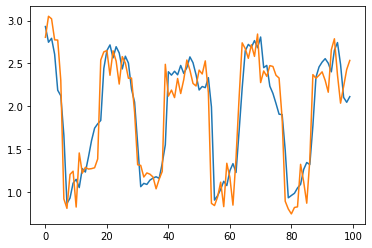

In [43]:
plt.plot(val_results2['Val Predictions2'][:100])
plt.plot(val_results2['Actuals'][:100])

In [44]:
test_predictions2 = model2.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions2':test_predictions2, 'Actuals':y_test1})
test_results2

,Test Predictions2,Actuals
0,2.596387,2.5725
1,2.595713,2.7000
2,2.667470,2.5275
3,2.564117,2.9175
4,2.789322,3.0425
...,...,...
382,2.261774,1.9425
383,2.226533,2.0125
384,2.260494,2.1425
385,2.332549,2.1975


In [45]:
mse_test2 = math.sqrt(mean_squared_error(test_predictions2,y_test1))
print(mse_test2)

0.2986431531135417


In [46]:
cons_max = cons.max()
print(cons_max)

3.79


In [47]:
# Calculating the % of Error
Error_percentage2 = round(((mse_test2*100)/cons_max), 2)
print(Error_percentage)

6.93


In [48]:
# Calculating the Model Precision
model2_precision = 100-Error_percentage2
print(" The Model 2 Precision is :  ", model2_precision, "%")

 The Model 2 Precision is :   92.12 %


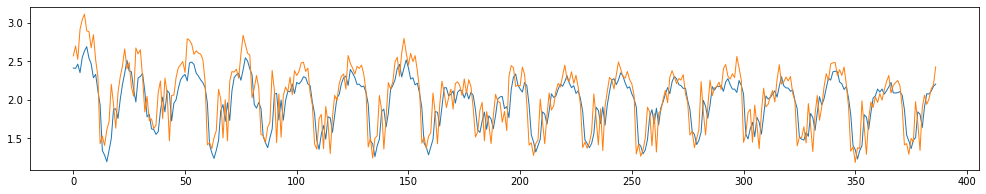

In [49]:
plt.figure(figsize=(17, 3))
plt.plot(test_results['Test Predictions'],lw=1)
plt.plot(test_results['Actuals'],lw=1)

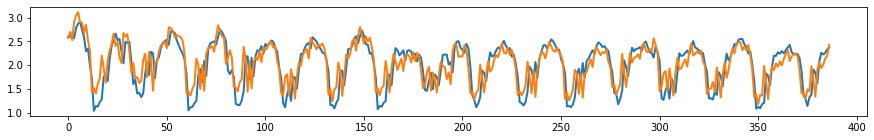

In [50]:
plt.figure(figsize=(15, 2))
plt.plot(test_results2['Test Predictions2'],lw=2)
plt.plot(test_results2['Actuals'],lw=2)

In [51]:
# Part 2

In [108]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

(     Predictions  Actuals
 0       2.528494   2.8450
 1       2.589953   2.8225
 2       2.568563   2.8000
 3       2.519108   2.9300
 4       2.543352   2.7550
 ..           ...      ...
 426     2.250665   1.9425
 427     2.246209   2.0125
 428     2.302517   2.1425
 429     2.375335   2.1975
 430     2.402964   2.4300
 
 [431 rows x 2 columns], 0.07701570552390564)

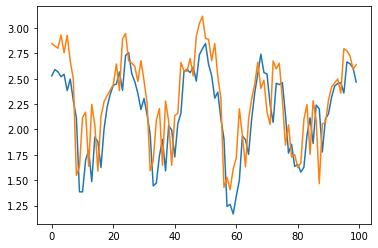

In [109]:
plot_predictions2(model2, X_test1, y_test1)

In [53]:
model2.save("model2.h5")
!ls

energy_consumption.csv	model1	model1.h5  model2  model2.h5  sample_data


In [54]:
files.download("model2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# END

In [ ]:
m

In [ ]:
m